In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

2023-08-31 09:52:19 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-08-31 09:52:19 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl.gz'))
print(len(real_game_texts), len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-08-31 09:52:21 - src.ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-08-31 09:52:22 - src.ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


98 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.968605,0.979319,0.964286,0.973077,0.976571,0.978192,0.919430,0.960971,0.998704,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.974280,0.978391,0.959478,0.966184,0.977509,0.978958,0.899454,0.915154,0.965182,0.973559
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.946566,0.972470,0.000000,0.000000,0.000000,0.000000,0.851207,0.904668,0.948186,0.955972
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.986871,0.980256,0.000000,0.000000,0.000000,0.000000,0.919430,0.960971,0.998704,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.983288,0.979510,0.000000,0.000000,0.000000,0.000000,0.964678,0.971974,0.973129,0.963587


In [6]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID, LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
model_date_id = 'full_features_no_in_data_all_2023_08_29'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



353


In [7]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [8]:
real_game_scores = full_tensor_scores[:, 0]

print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
print(f'20th percentile negative energy: {torch.quantile(negatives_scores.ravel(), 0.2)}')

Real game scores: -88.4745 ± 0.8686, min = -92.6684, max = -86.9446
20th percentile negative energy: -83.34337615966797


In [9]:
steps = torch.linspace(0, 1, 11)
deciles = torch.quantile(negatives_scores.ravel(), steps)
print(steps)
print(f'Energy deciles: {deciles}')

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])
Energy deciles: tensor([-91.0132, -85.9437, -83.3434, -81.6257, -80.1435, -78.4918, -76.7135,
        -74.3037, -70.5485, -62.4902,   1.5284])


Weights mean: 0.1512, std: 2.5445, bias: 0.0100


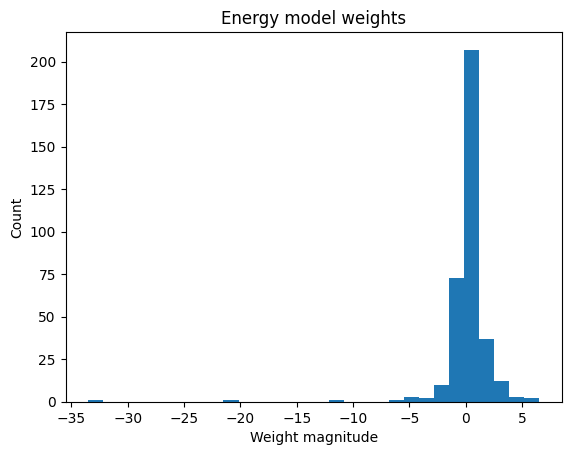

In [10]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [11]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (37, 10.48%) of the weights have magnitude < 0.0536
Approximately 25.0% (90, 25.50%) of the weights have magnitude < 0.1876
Approximately 50.0% (179, 50.71%) of the weights have magnitude < 0.5092
Approximately 75.0% (265, 75.07%) of the weights have magnitude < 1.0989
Approximately 90.0% (318, 90.08%) of the weights have magnitude < 2.1442
Approximately 95.0% (336, 95.18%) of the weights have magnitude < 3.1292
Approximately 99.0% (350, 99.15%) of the weights have magnitude < 6.5330


In [12]:
from src.fitness_features_by_category import *


def print_weights_summary_by_category(model_weights: torch.Tensor, all_feature_columns: typing.List[str], return_lines: bool = False):
    abs_weights = model_weights.abs()
    sorted_feature_names = [t[1] for t in sorted([(abs_weights[i], all_feature_columns[i]) for i in range(len(all_feature_columns))], key=lambda x: x[0], reverse=True)]

    lines = []
    all_assigned_features = set()

    for category, features in FEATURE_CATEGORIES.items():
        category_feature_list = []
        for feature in features:
            if isinstance(feature, re.Pattern):
                category_feature_list.extend([f for f in feature_columns if feature.match(f)])

            else:
                category_feature_list.append(feature)

        all_assigned_features.update(category_feature_list)
        
        mean_abs_weight = np.mean([abs_weights[feature_columns.index(feature)] for feature in category_feature_list])
        sum_abs_weight = np.sum([abs_weights[feature_columns.index(feature)] for feature in category_feature_list])
        mean_sorted_index = np.mean([sorted_feature_names.index(feature) for feature in category_feature_list])
        prefix = f'For category {category} with {len(category_feature_list)} features'
        line = f'{prefix:54} | mean abs weight is {mean_abs_weight:5.2f} | sum abs weight is {sum_abs_weight:6.2f} | mean sorted index is {mean_sorted_index:6.2f}'
        if return_lines:
            lines.append(line)
        else:
            print(line)

    unassigned_features = [f for f in feature_columns if f not in all_assigned_features]
    if len(unassigned_features) > 0:
        print(f'Unassigned features: {unassigned_features}')

    if return_lines:
        return lines


In [13]:
l1_model, _ = utils.load_model_and_feature_columns('full_features_no_in_data_all_L1_2023_08_29')

In [14]:
MODEL_NAMES = ['Baseline', 'L1']
models = [cv_energy_model, l1_model]

for model_name, model in zip(MODEL_NAMES, models):
    display(Markdown(f'### For model {model_name}'))
    print_weights_summary_by_category(model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze(), feature_columns)
    

### For model Baseline

For category grammar_context with 12 features          | mean abs weight is  1.87 | sum abs weight is  22.47 | mean sorted index is 113.50
For category ngram_and_data_based with 7 features      | mean abs weight is 11.52 | sum abs weight is  80.67 | mean sorted index is  25.00
For category counting with 101 features                | mean abs weight is  0.53 | sum abs weight is  53.75 | mean sorted index is 208.23
For category forall with 18 features                   | mean abs weight is  1.25 | sum abs weight is  22.57 | mean sorted index is 175.83
For category predicate_under_modal with 50 features    | mean abs weight is  0.49 | sum abs weight is  24.54 | mean sorted index is 209.90
For category predicate_role_filler with 138 features   | mean abs weight is  0.88 | sum abs weight is 120.89 | mean sorted index is 155.34
For category compositionality with 10 features         | mean abs weight is  0.06 | sum abs weight is   0.59 | mean sorted index is 315.00
For category grammar_use wi

### For model L1

For category grammar_context with 12 features          | mean abs weight is  0.24 | sum abs weight is   2.86 | mean sorted index is 153.83
For category ngram_and_data_based with 7 features      | mean abs weight is  2.63 | sum abs weight is  18.44 | mean sorted index is 131.14
For category counting with 101 features                | mean abs weight is  0.02 | sum abs weight is   1.65 | mean sorted index is 155.45
For category forall with 18 features                   | mean abs weight is  0.17 | sum abs weight is   3.09 | mean sorted index is 192.28
For category predicate_under_modal with 50 features    | mean abs weight is  0.00 | sum abs weight is   0.07 | mean sorted index is 202.56
For category predicate_role_filler with 138 features   | mean abs weight is  0.00 | sum abs weight is   0.60 | mean sorted index is 178.75
For category compositionality with 10 features         | mean abs weight is  0.00 | sum abs weight is   0.00 | mean sorted index is 272.40
For category grammar_use wi

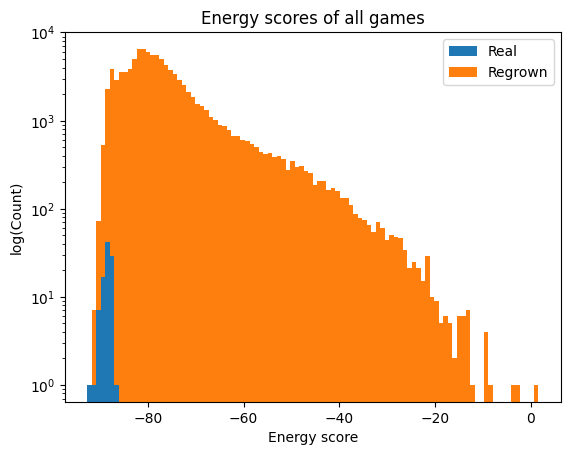

In [15]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

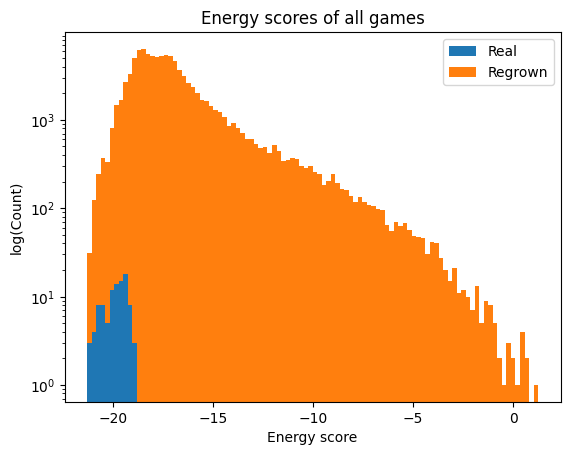

In [16]:
utils.plot_energy_histogram(l1_model, full_tensor)

In [17]:
pred_features = [f for f in feature_columns if FEATURE_CATEGORIES['predicate_role_filler'][0].match(f)]
l1_weights = l1_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()
sorted_features = sorted([(l1_weights[i], feature_columns[i]) for i in range(len(feature_columns))], key=lambda x: x[0], reverse=False)
sorted_pred_features = [f for f in sorted_features if f[1] in pred_features]

In [18]:
K = 20
lines = []

lines.append('### Role-filler features with largest negative weights:')
for i in range(K):
    lines.append(f'{i+1}. {sorted_pred_features[i][1]} ({sorted_pred_features[i][0]:.4f})')

lines.append('### Role-filler features with largest positive weights:')
for i in range(K):
    lines.append(f'{i+1}. {sorted_pred_features[-(i + 1)][1]} ({sorted_pred_features[-(i + 1)][0]:.4f})')

display(Markdown('\n'.join(lines)))

### Role-filler features with largest negative weights:
1. touch_arg_types_balls_blocks_constraints (-0.0069)
2. on_arg_types_room_features_blocks_constraints (-0.0062)
3. touch_arg_types_balls_furniture_constraints (-0.0042)
4. distance_arg_types_blocks_receptacles_setup (-0.0040)
5. adjacent_arg_types_agent_receptacles_constraints (-0.0037)
6. in_arg_types_receptacles_blocks_constraints (-0.0036)
7. in_motion_arg_types_blocks_constraints (-0.0036)
8. in_arg_types_receptacles_balls_constraints (-0.0035)
9. adjacent_arg_types_agent_ramps_constraints (-0.0035)
10. distance_arg_types_furniture_ramps_constraints (-0.0035)
11. on_arg_types_furniture_any_object_constraints (-0.0035)
12. in_motion_arg_types_receptacles_constraints (-0.0034)
13. distance_arg_types_blocks_blocks_setup (-0.0033)
14. adjacent_arg_types_blocks_room_features_setup (-0.0032)
15. distance_arg_types_agent_balls_constraints (-0.0032)
16. on_arg_types_furniture_large_objects_constraints (-0.0031)
17. touch_arg_types_balls_room_features_constraints (-0.0031)
18. agent_holds_arg_types_receptacles_constraints (-0.0030)
19. agent_holds_arg_types_blocks_constraints (-0.0029)
20. in_arg_types_receptacles_building_constraints (-0.0027)
### Role-filler features with largest positive weights:
1. in_arg_types_other_constraints (0.3923)
2. on_arg_types_other_constraints (0.0435)
3. on_arg_types_other_setup (0.0063)
4. in_motion_arg_types_any_object_constraints (0.0057)
5. agent_holds_arg_types_balls_constraints (0.0043)
6. in_motion_arg_types_balls_constraints (0.0037)
7. agent_holds_arg_types_any_object_constraints (0.0032)
8. on_arg_types_furniture_receptacles_setup (0.0025)
9. distance_arg_types_receptacles_room_features_setup (0.0025)
10. adjacent_arg_types_other_constraints (0.0021)
11. distance_arg_types_other_setup (0.0020)
12. adjacent_arg_types_agent_room_features_constraints (0.0020)
13. distance_arg_types_any_object_room_features_constraints (0.0018)
14. on_arg_types_furniture_balls_setup (0.0014)
15. object_orientation_arg_types_large_objects_orientations_setup (0.0013)
16. adjacent_arg_types_furniture_receptacles_setup (0.0010)
17. on_arg_types_blocks_blocks_constraints (0.0008)
18. in_arg_types_building_receptacles_constraints (0.0004)
19. on_arg_types_room_features_balls_setup (0.0003)
20. in_arg_types_receptacles_large_objects_constraints (0.0003)

## Looking at comparing the models on the negatives from the test set

In [29]:
no_reg_sweep_data = utils.load_data('2023_08_29', 'data/fitness_cv', 'fitness_sweep_full_features_no_in_data_all')
print(no_reg_sweep_data.keys())
no_reg_test_scores = no_reg_sweep_data['cv'].best_estimator_.transform(no_reg_sweep_data['test_tensor'])
no_reg_test_real_game_scores = no_reg_test_scores[:, 0]
no_reg_test_negatives_scores = no_reg_test_scores[:, 1:]

no_reg_argsort = torch.argsort(no_reg_test_negatives_scores.ravel())
no_reg_position_to_index = torch.zeros_like(no_reg_argsort)
no_reg_position_to_index[no_reg_argsort] = torch.arange(len(no_reg_argsort))

no_reg_indices_with_better_negative = set(torch.where((no_reg_test_negatives_scores < no_reg_test_real_game_scores[:, None, :]).ravel())[0].numpy())
print(len(no_reg_indices_with_better_negative))



l1_sweep_data = utils.load_data('2023_08_29', 'data/fitness_cv', 'fitness_sweep_full_features_no_in_data_all_L1')
l1_test_scores = l1_sweep_data['cv'].best_estimator_.transform(l1_sweep_data['test_tensor'])
l1_test_real_game_scores = l1_test_scores[:, 0]
l1_test_negatives_scores = l1_test_scores[:, 1:]

l1_argsort = torch.argsort(l1_test_negatives_scores.ravel())
l1_position_to_index = torch.zeros_like(l1_argsort)
l1_position_to_index[l1_argsort] = torch.arange(len(l1_argsort))

l1_indices_with_better_negative = set(torch.where((l1_test_negatives_scores < l1_test_real_game_scores[:, None, :]).ravel())[0].numpy())
print(len(l1_indices_with_better_negative))

dict_keys(['cv', 'train_tensor', 'test_tensor', 'results', 'feature_columns'])
143
59


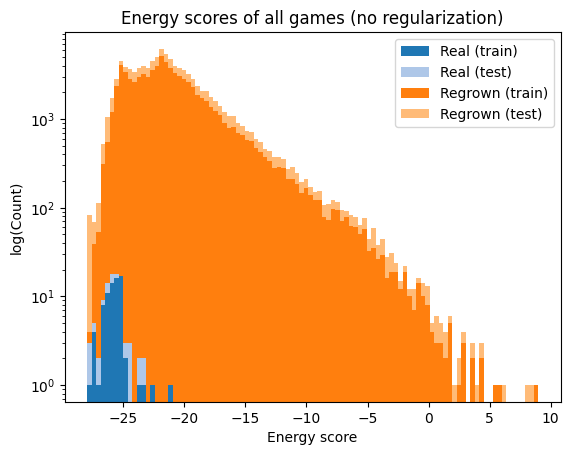

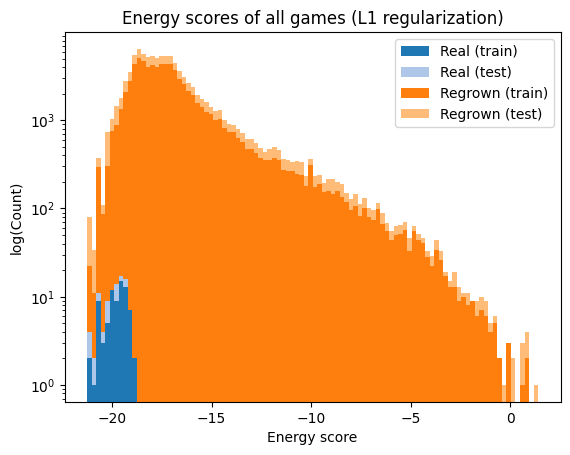

In [32]:
utils.plot_energy_histogram(
    no_reg_sweep_data['cv'], 
    no_reg_sweep_data['train_tensor'], 
    no_reg_sweep_data['test_tensor'],
    histogram_title_note='no regularization')

utils.plot_energy_histogram(
    l1_sweep_data['cv'],
    l1_sweep_data['train_tensor'],
    l1_sweep_data['test_tensor'],
    histogram_title_note='L1 regularization')

In [30]:
better_negative_both = no_reg_indices_with_better_negative.intersection(l1_indices_with_better_negative)
better_negative_l1_only = l1_indices_with_better_negative.difference(no_reg_indices_with_better_negative)
better_negative_no_reg_only = no_reg_indices_with_better_negative.difference(l1_indices_with_better_negative)

print(f'Both: {len(better_negative_both)}, L1 only: {len(better_negative_l1_only)}, No reg only: {len(better_negative_no_reg_only)}')

Both: 36, L1 only: 23, No reg only: 107


In [34]:
index_diffs = no_reg_position_to_index - l1_position_to_index
index_diffs.topk(10, largest=False)

torch.return_types.topk(
values=tensor([-15683, -12719, -12145, -11810, -11493, -11491, -11321, -11310, -11270,
        -11236]),
indices=tensor([  987,   149,   170, 11597,  2585,  2109,  1861,   851,    97,  2487]))

In [35]:
utils.evaluate_energy_contributions(cv_energy_model, full_tensor, 987, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    


Original game index: 0 | Negative game row: 0 | Negative game col: 987


### Energy of real game: -88.430 | Energy of regrown game: -79.694 | Difference: 8.736

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                 | Features decreasing energy (= more real)                                                |
|------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| ast_ngram_full_n_5_score: **6.203** = (0.968 => 0.783) * -33.496                         | agent_holds_arg_types_balls_constraints: **-1.296** = (1.000 => 0.000) * 1.296          |
| ast_ngram_constraints_n_5_score: **2.839** = (0.979 => 0.842) * -20.659                  | agent_holds_arg_types_large_objects_constraints: **-0.184** = (0.000 => 1.000) * -0.184 |
| in_arg_types_receptacles_balls_constraints: **0.819** = (1.000 => 0.000) * -0.819        | in_motion_arg_types_balls_constraints: **-0.183** = (1.000 => 0.000) * 0.183            |
| predicate_found_in_data_constraints_prop: **0.653** = (1.000 => 0.900) * -6.528          | touch_arg_types_balls_ramps_constraints: **-0.181** = (1.000 => 0.000) * 0.181          |
| in_arg_types_receptacles_large_objects_constraints: **0.051** = (0.000 => 1.000) * 0.051 |                                                                                         |
| in_motion_arg_types_large_objects_constraints: **0.015** = (0.000 => 1.000) * 0.015      |                                                                                         |

### Game Diffs

n,1,(define (game 6172feb1665491d1efbce164-0) (:domain medium-objects-room-v1),n,1,(define (game 6172feb1665491d1efbce164-0-987-nd-11-rd-2-rs-constraints-sk-prior2
,,,,>,) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?r - triangular_ramp),,4,(exists (?h - hexagonal_bin ?r - triangular_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?h ?r) 1),,6,(< (distance ?h ?r) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


In [36]:
utils.evaluate_energy_contributions(l1_model, full_tensor, 987, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    


Original game index: 0 | Negative game row: 0 | Negative game col: 987


### Energy of real game: -19.616 | Energy of regrown game: -16.218 | Difference: 3.398

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                          | Features decreasing energy (= more real)                                                |
|-----------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| ast_ngram_full_n_5_score: **3.405** = (0.968 => 0.783) * -18.388                  | agent_holds_arg_types_balls_constraints: **-0.004** = (1.000 => 0.000) * 0.004          |
| in_arg_types_receptacles_balls_constraints: **0.003** = (1.000 => 0.000) * -0.003 | in_motion_arg_types_balls_constraints: **-0.004** = (1.000 => 0.000) * 0.004            |
| touch_arg_types_balls_ramps_constraints: **0.001** = (1.000 => 0.000) * -0.001    | in_motion_arg_types_large_objects_constraints: **-0.003** = (0.000 => 1.000) * -0.003   |
|                                                                                   | agent_holds_arg_types_large_objects_constraints: **-0.001** = (0.000 => 1.000) * -0.001 |

### Game Diffs

n,1,(define (game 6172feb1665491d1efbce164-0) (:domain medium-objects-room-v1),n,1,(define (game 6172feb1665491d1efbce164-0-987-nd-11-rd-2-rs-constraints-sk-prior2
,,,,>,) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?r - triangular_ramp),,4,(exists (?h - hexagonal_bin ?r - triangular_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance ?h ?r) 1),,6,(< (distance ?h ?r) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)
